# 1. Data 

In [ ]:
import ijson
import networkx as nx
import pandas as pd
import itertools
from itertools import combinations
from collections import Counter
import json
import pickle
import heapq
from prettytable import PrettyTable
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from scipy.stats import percentileofscore
import ipywidgets as widgets
from IPython.display import display, clear_output
from tabulate import tabulate
from class_graph import graph
import frontend
import backend

## Data pre-processing

**The dataset is quite large and may not fit in your memory when you try constructing your graph. So, what is the solution? You should focus your investigation on a subgraph. You can work on the most connected component in the graph. However, you must first construct and analyze the connections to identify the connected components.**

#### Identify the top 10,000 papers with the highest number of citations.

First we read in one item of our json file to get a feeling for our data

In [2]:
counter = 0
limit = 1 # Number of objects to read
dato=[]

with open("dblp.v12.json", 'rb') as f:
    for record in ijson.items(f, 'item'):
        if counter >= limit:
            break
        # Process the record here
        dato.append(record)
        counter += 1

In [3]:
dato

[{'id': 1091,
  'authors': [{'name': 'Makoto Satoh',
    'org': 'Shinshu University',
    'id': 2312688602},
   {'name': 'Ryo Muramatsu', 'org': 'Shinshu University', 'id': 2482909946},
   {'name': 'Mizue Kayama', 'org': 'Shinshu University', 'id': 2128134587},
   {'name': 'Kazunori Itoh', 'org': 'Shinshu University', 'id': 2101782692},
   {'name': 'Masami Hashimoto', 'org': 'Shinshu University', 'id': 2114054191},
   {'name': 'Makoto Otani', 'org': 'Shinshu University', 'id': 1989208940},
   {'name': 'Michio Shimizu',
    'org': 'Nagano Prefectural College',
    'id': 2134989941},
   {'name': 'Masahiko Sugimoto',
    'org': 'Takushoku University, Hokkaido Junior College',
    'id': 2307479915}],
  'title': 'Preliminary Design of a Network Protocol Learning Tool Based on the Comprehension of High School Students: Design by an Empirical Study Using a Simple Mind Map',
  'year': 2013,
  'n_citation': 1,
  'page_start': '89',
  'page_end': '93',
  'doc_type': 'Conference',
  'publisher': 

In order to get the 10000 papers with the most citations we read in every paper(itself a dictionnary) and only store the id of the paper (to recognize it later) and the number of references in a dictionnary.

In [6]:
with open('dblp.v12.json', 'r') as f:
    papers = ijson.items(f, 'item')
    new_dict = {}
    for d in papers:
        id = d["id"]
        num_citations = d["n_citation"] if "n_citation" in d else 0
        new_dict[id] = num_citations

Now we want to sort our dictionnary. We do this by creating tuples of our key/value pairs and storing them in a list. Then it is sorted by the second element of each tuple (number of citations) in descending order.

In [7]:
sorted_dict = sorted(new_dict.items(), key=lambda x:x[1], reverse=True)

We only want the 10000 papers with the most citations, that's why only consider the first 10000 tuples in our list. It is possible, that there are papers ingored that have the same number of citations as some that are kept. We are consciously ignoring this.

In [8]:
sorted_dict = sorted_dict[0:10000]

In [9]:
sorted_dict

[(2041404167, 48327),
 (1639032689, 44175),
 (2912565176, 42437),
 (2151103935, 35541),
 (2911964244, 34741),
 (1973948212, 32053),
 (2153635508, 31047),
 (2156909104, 28886),
 (1791587663, 25855),
 (2119821739, 22276),
 (1995875735, 22122),
 (2103441770, 21301),
 (2126105956, 21153),
 (2146058063, 20976),
 (2108234281, 20162),
 (2145023731, 19801),
 (2161969291, 19433),
 (2171074980, 19427),
 (1880262756, 19392),
 (2137015675, 18732),
 (2082928585, 18098),
 (1686810756, 18029),
 (1522301498, 17497),
 (2133665775, 17339),
 (2161444534, 17261),
 (2121863487, 17231),
 (2132629607, 17135),
 (2011039300, 17118),
 (2163605009, 16802),
 (2132984323, 16652),
 (2064675550, 16450),
 (2125055259, 16276),
 (2085261163, 15271),
 (2296616510, 15261),
 (2169528473, 15226),
 (2194775991, 15184),
 (1667165204, 14972),
 (2079325629, 14797),
 (2100379340, 14775),
 (2104095591, 14470),
 (1595159159, 14257),
 (2133990480, 13917),
 (2173213060, 13866),
 (2159080219, 13820),
 (2139212933, 13522),
 (21246374

Now we extract the id's we are interested in and store it in a list

In [10]:
relevant_ids= [tup[0] for tup in sorted_dict]

Now we have what we need to extract the 10000 papers with the most citations from our json file. We store them in a list called graph_list. This is a list of dictionnaries. Alternatively we could have also just extracted the information that was necessary to construct the graph.

In [11]:
with open('dblp.v12.json', 'r') as f:
    papers = ijson.items(f, 'item')
    graph_list = []
    for paper in papers:
        if paper['id'] in relevant_ids:
            graph_list.append(paper)  
      

## Graphs setup



**Citation graph: This graph should represent the paper's citation relationships. We want this graph to be unweighted and directed. The citation should represent the citation given from one paper to another. For example, if paper A has cited paper B, we should expect an edge from node A to B. Nodes: You can consider each of the papers as your nodes. Edges: Only consider the citation relationship between these 10,000 papers and ignore the rest**


In [12]:
#Citation graph
#Initializes a directed graph, that can have double edges
G= nx.MultiDiGraph()
#Creating the nodes
for paper in graph_list:
    G.add_node(paper['id'])
#Creating the edges
for paper in graph_list:
    #Condition to avoid error as it is possible that a paper has no citations
    if 'references' in paper:
        for element in paper['references']:
            # Condition to verify that only the citation relationship of the top 10000 papers is being looked at
            if element in relevant_ids:
                G.add_edge(paper['id'],element)

**Collaboration graph: This graph should represent the collaborations of the paper's authors. This graph should be weighted and undirected. Consider an appropriate weighting scheme for your edges to make your graph weighted.  Nodes: The authors of these papers would be your nodes. Edges: Only consider the collaborations between the authors of these 10,000 papers and ignore the rest.**

The creation of the collaboration graph is a little bit more complicted, therefor we split in several steps

First we initialize an undirected graph

In [13]:
#Initialization of the collaboration graph
N= nx.Graph()    

Now we are creating the nodes. Therefor we iterate through our list of dictionnaries(our papers) and save them in a list. This list is later converted to a set to avoid creating the same node several times.

In [14]:
#Initialization of empty list
author_list=[]
#Extracting the authors
for paper in graph_list:
    for author in paper['authors']:
        author_list.append(author['id'])
#Cooveritng it to a set
nodes=set(author_list)
#Creating the nodes
for node in nodes:
    N.add_node(node)

Now we have to create the edges. We consider it a collabortaion if two authors worked on a paper together.We consider a collaboration as stronger if the authors worked together on many papers.Therefor our weight will be the number of times two authors worked together. To show these collaborations by edges we write two helping functions.

As for a lot of papers there are several authors, we want to create tuples of each combination of authors (edges). Our permutation function helps us doing that.

In [15]:
def permutation(list_authors_pp):
    # Sort the tuples to make sure they are always created in the same order
    sorted_list_authors_pp= sorted(list_authors_pp)
    #Create tuples of all posible combinations and store them in a list
    all_combinations = list(combinations(sorted_list_authors_pp, 2))
    # Store the tuples in combination_list
    for combo in all_combinations:
        combination_list.append(combo)


Our second function counts the occurence of each tuple and returns a list of tuples. The first element of each tuple is a tuple that contains the id's of the two authors (edge). The second element of each tuple is the number of times the two authors worked together (weight).

In [16]:
def count_tuples(tuple_list):
    #Count the tuples (collaborations) 
    counter = Counter(tuple_list)
    #Store the new tuples in a list
    result_list = [(key, (count)) for key, count in counter.items()]
    return result_list


Now that we have our two helping functions, we create our weighted edges. We iterate through the authors of the individual papers (dictionnaries) and get the collaboration combinations of the authors for every single paper. We count the occurence of every single collaboration between two authors, which will be the weight of the edges, that we then create.

In [17]:
#Initialize list for collaboration combinations
combination_list=[]

#Iterate through the papers
for paper in graph_list:

    #Initialize list for the author id's of a single paper
    list_authors_pp=[]

    for author in paper['authors']:
        list_authors_pp.append(author['id'])
        
    #Get the author pairs (collaborations) of a single paper
    permutation(list_authors_pp)
    
#Count all the tupes and create a new tuple with weights
tuples_weighted= count_tuples(combination_list)

#Create the edges
for tuplo in tuples_weighted:
    N.add_edge(tuplo[0][0], tuplo[0][1], weight=tuplo[1])


__________

# 2 - Controlling System

In order not to have to run the whole notebook everytime since it takes some time, we created some files that we load in memory when needed (in this case, all the files are loaded in the frontend file for the visualization.)

In [ ]:
if False:
    # Retrieve data of the collaboration graph and store it in a convinient format
    collaboration_nodes = list(nodes)
    collaboration_edges = [t[0] for t in tuples_weighted]
    collaboration_weigths = dict({t[0]: t[1] for t in tuples_weighted})

    collaboration_data = {'nodes': collaboration_nodes, 'edges': collaboration_edges, 'weigths': collaboration_weigths, 'dir': False}

    #retrieve citations' graph data and store it
    citation_nodes = list(G.nodes())
    citation_edges = list(G.edges())

    citation_data = {'nodes': citation_nodes, 'edges': citation_edges, 'weigths' : dict(), 'dir': True}

    # save graphs data as pikle file 
    with open('collaboration.pkl', 'wb') as fp:
        pickle.dump(collaboration_data, fp)

    fp.close()

    with open('citation.pkl', 'wb') as fp:
        pickle.dump(citation_data, fp)

    fp.close()

    # Dictionary with the data of the top 10.000 papers
    graph_data = dict()
    for graph_item in graph_list:
        graph_data.update({graph_item['id']: graph_item})

    with open('graphdata.pkl', 'wb') as f:
        pickle.dump(graph_data, f)

    f.close()

## 2.1 - Backend 

### Functionality 1 - Graph's features

Here we create the functionality 1. In each step, we compute one of the metrics requested and then print them as result. <br>
You can investigate the function in the backend.py file.

### Functionality 2 - Nodes' contribution

Here we create the functionality 2. In each step, we compute one of the metrics requested and then print them as result.  <br>
For this step, we use the networkx implemented functions. <br>
You can investigate the function in the backend.py file.

### Interlude: Top N papers and top N authors; "graph" class

In order to retrieve the top N authors and papers we defined two functions, whom code can be found in the "backend" file.
These functions are needed for functionalities 3, 4 and 5. They're constructed on the following considerations. 

- TopN papers are the N papers with more citations;
- TopN authors are the N authors with more publications.

How to retrieve these informations: 
- in the collaboration graph (authors' graph), the total number of publications of each author an be retrieved as the sum of the weigths adjacent to the author's node; then we can store these info and retrieve the topN authors with a heap structure, and induce a subgraph and work on it.
- in the citation graph (papers' graph), the number of citation of each paper can be retrieved as the indegree of the node correspinding to it; then we retrieve the top N with a heap structure and induce a subgraph as before.

Beisides, we wanted to highlight that since we couldn't use Networkx methods for the follosing functionalities, we created a class called "graph" to handle the data of this home work in a convenient way. The class definition and its methods can be found in the file "class_graph.py". The methods we implemented compute some basic operations on the graphs; we think their names are pretty clear so we won't list or comment them here.

Besides, all the code of the backend section can be found in the file "*backend.py*".

### Functionality 3 - Shortest ordered walk

The shortest path that connects all the nodes in the sequence in order is the one that minimizes the number of steps for each intermediate stop to be done. Indeed, we want to minimize $\sum_P \sum_{e \in E}{\mathbb{1}_{ \left( e \in P \right)}(e)} = \sum_{i=1}^{n-1}  \sum_{e \in E}{\mathbb{1}_{\left( e \in P_i \right)}(e)}$ where P is a path from source to sink that goes throguh the sequence, $P_i$ is a path that goes from node $a_i$ to $a_{i+1}$ for each $i$, which ordered sequence returns exactly the path $P$ (note that such decomposition is always doable).    
The fact that we need to mantain the order ov visitation of the nodes makes the problem easier to solve: we can "separate" it by computing the shortest path $P_i$ for each $i$ and then concatenate the resulting paths to obtain $P$. 
 
The functions we implemented follows this approach; the path $P_i$ is computed using Dijkistra's algorithm in the function "*shortest_path*" and the whole parth is computed in the function "*shortest_path_sequence*".

### Functionality 4 - Disconnecting Graphs

This functionality request can be interpreted as a MinCut problem. For this reason, knowing that the capacity of a minimal cut is equal to the value of a maxmum flow, we implemented a variant of Ford-Fulkerson algorithm for undirected graphs to compute the maxflow and we retrieved the cut set through DFS. For this purpose, we also implemented a function that checks the presesence of a path between to nodes and retrieves the path if the two nodes are connected.
To be able to disconnect the nodes, we implemented another function that firstly construct the subgraph of the top N nodes, then applies the Ford-Fulkerson algorithm on this subgraph and from the final residual graph we construct the cutset and get its capacity.

The functions we are referring to are "*checkpath_DFS*", "*FordFulkerson*" and "*node_connected_component*".

### Functionality 5 - Extracting Communities

For this functionalty, we implemented the Girvan-Newman Algorithm. 
To compute Edge Betweeness Centrality of all the edges in the graph, we used a function that computes contribution to it from the shortest paths starting from a given node, then we loop over all the nodes in the graphs and update the total edge betweeness centrality by adding the "new" contribution. The stopping criteria for the loop of the removal of the edges in this case is simply the augmentation of the number of connected components in the graph, since the request is to retrieve the minimal number of edges to remove to get communities.

## 2.2 Frontend

Interlude: Create authors' and papers' dicionary to set the labels in the visualization of the graphs

In [71]:
if False: 
    # Authors dictionary: {author's id: author's name}
    authors_list = []
    for key in graph_data:
        authors_list += graph_data[key]['authors']

    authors_dict = dict({author['id'] : author['name'] for author in authors_list})

    # Papers' dictionary: {paper's id: paper's title}
    papers_dict = dict({id: graph_data[id]['title'] for id in graph_data})

    file = open('papersd.pkl', 'wb')
    pickle.dump(papers_dict, file)
    file.close()
    file = open('authorsd.pkl', 'wb')
    pickle.dump(authors_dict, file)
    file.close()


To fulfill this request, we created an interactive visualization/control system that allows the user to select between the functionalities implemented in the backend section, after selecting one of the two graphs. The control system also allows the user to input the functions inputs.   
All the code for the frontend section can be found in the "*frontndd.py*" file.

Unfortunatly, you need to run the file to be able to get the interactive part of the menu, so we added some screenshots of how the menu looks, and we added some outputs of it.
Here is the menu aspect.

**Home section**

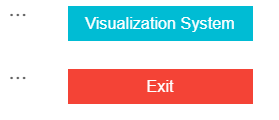

**Graph selection section** 
(showed after selecting "Visualization System")

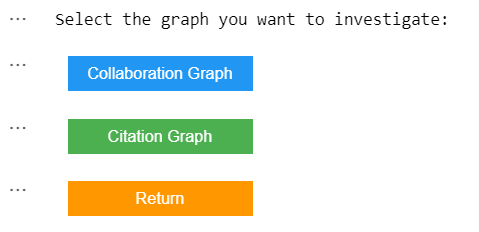

**Collaboration Graph section** (showed after selecting "Collaboration Graph") 

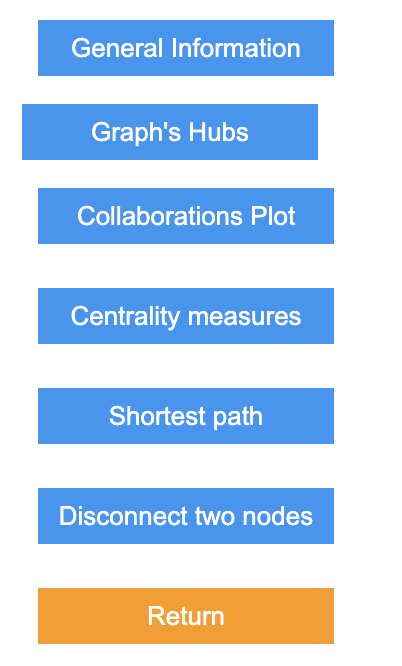

**Citation Graph section** (showed atfter selecting "Citation Graph")

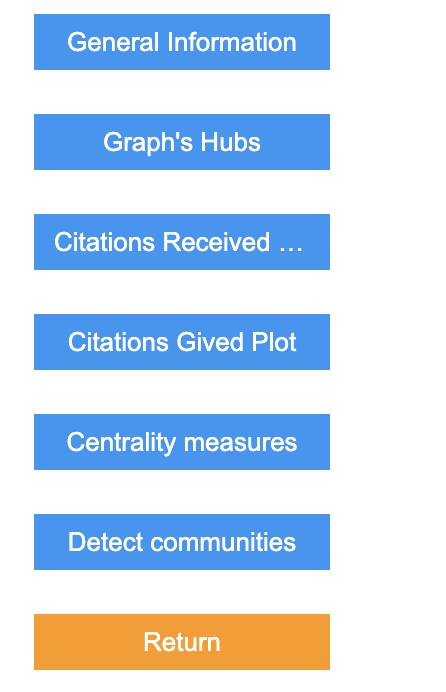

Here we show some of the outputs of the visualization system. Before the reports there's a little introduction followed by the sequence of buttons to select in the menu's interface (in sequence) and the inputs to enter (when needed) to get our sme outputs. 

### Visualization 1 - Visualize graph features

<code style="background:orange;color:black">**Introduction:**</code> <br>
The main idea here is to present an interactive menu where the user can decide the steps to take. <br>
In few words, we take the function created before and the user is able to navigate a menu choosing the graphs and the features they want to inspect. <br>

The systems opens asking the user wheather they want to enter the Visualisation System or exit. <br>
If entered, user will be able to choose the graph or return back to the home. Once the graph is chosen, the user will be able to retrieve the feature they want. <br>
The features are as requested: <br>
- Table containing general information <br>
- Table that lists the graph's hubs <br>
- Plot with citation received (only Citation graph) <br>
- Plot with citation gived (only Citation graph) <br>
- Plot number of collaborators per author (only collaboration graph) <br>
Please, note that not all features are visible for both graphs as some are specific only for one of them and vice-versa. <br>

**Visualization System -> Citation Graph -> Citation Given Plot**

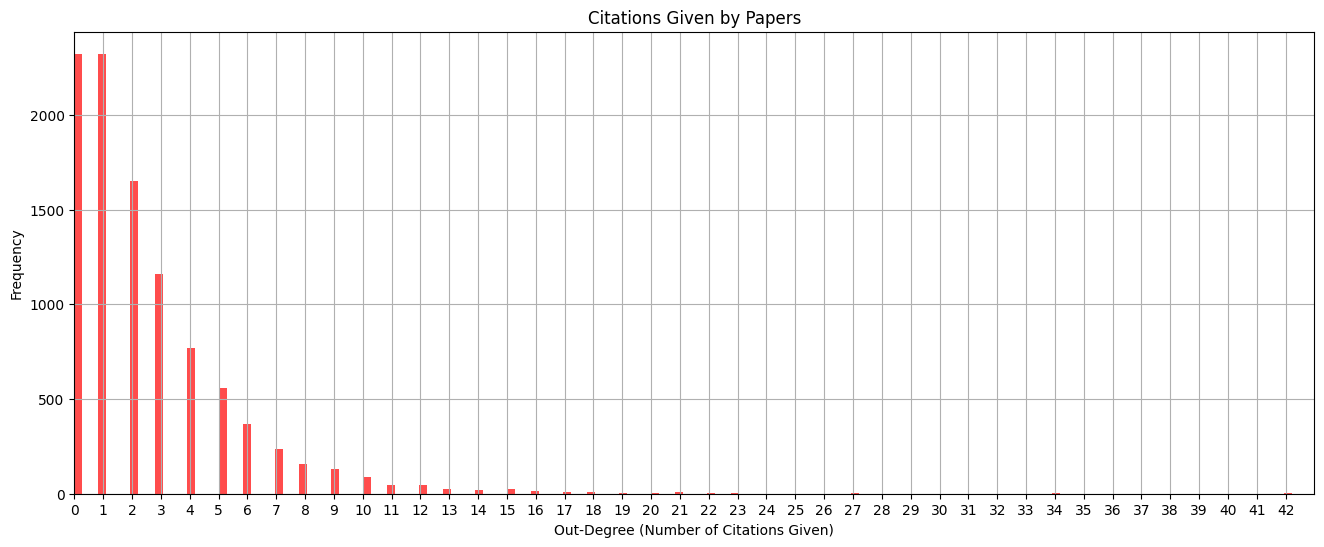

In [ ]:
%run ./frontend

---

<code style="background:red;color:black">**little comment:**</code> <br>
We have a lot of results. <br>
We can understand that we are dealing with a sparse and a dense graph with several information that can be investigated into the general info table (such as n of nodes, edges, hubs etc..). <br>
Then we can investigate the number of citations gived and received and the colaborators of authors thanks to plots. <br>
In this specific plot, we investigate the citation gived by paper (references). <br>
We can clearly observe that the more citation a paper give, the less the number of the papers are. So, we find a lot of papers with just one or two citations (also 0) and very few with several citations. <br>
This is problematic from a "substance" point-of-view. In a scientific field a paper with 0, 1 or 2 references is not very consistent and should be avoided/not-trusted. <br>
For Instance, in the biological field, a paper with such few references will not be taken seriously by peers and there is little chance for it to be published in important journals (such as "Current Biology"). On one hand, this is due to the fact that infromation must be cited and it is very rare (or impossible) that all data/knowledge contained in a paper is completely from the author(s). On the other, few references may indicate poor organisation and seriousness from the author(s) or fabrication/manipulation of data and/or results.  <br>
To conclude, the papers in this dataset may not be very consistent due to their lack of references.

---

### Visualization 2 - Visualize the node's contribution

<code style="background:orange;color:black">**Introduction:**</code> <br>
As before, we create an interactive menu for the user. <br>
It is very similar to the previous one but this time after choosing the graph, you are asked to input a number (our node of interest) <br>
Then the system will return the result from the function previously created and plot it in a nice table.

After selecting the button "Centrality measures" from one of the two graohs interface, this is what th menu looks like when asking for the inputs:

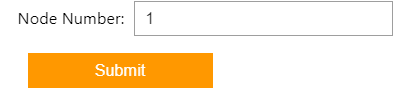

**Collaboration Graph**

Visualization System -> Collaboration Graph -> Centrality measures -> Node Number: 156762113

In [ ]:
%run ./frontend

Retrieving results; this could take some minutes, please wait...
Result for node 156762113 in the Collaboration Graph:
Graph Features Report for 'Collaboration Graph':
╒══════════════════════╤═════════════╕
│ Feature              │       Value │
╞══════════════════════╪═════════════╡
│ Betweenness          │ 0           │
├──────────────────────┼─────────────┤
│ Pagerank             │ 4.77134e-05 │
├──────────────────────┼─────────────┤
│ Closeness Centrality │ 0.000527495 │
├──────────────────────┼─────────────┤
│ Degree Centrality    │ 0.000550288 │
╘══════════════════════╧═════════════╛


**Citation Graph**

Visualization System -> Citation Graph -> Centrality measures -> Node Number: 2893933380

In [ ]:
%run ./frontend

Retrieving results; this could take some minutes, please wait...
Result for node 2893933380 in the Citation Graph:
Graph Features Report for 'Citation Graph':
╒══════════════════════╤═════════════╕
│ Feature              │       Value │
╞══════════════════════╪═════════════╡
│ Betweenness          │ 9.35727e-06 │
├──────────────────────┼─────────────┤
│ Pagerank             │ 7.83614e-05 │
├──────────────────────┼─────────────┤
│ Closeness Centrality │ 0.00040004  │
├──────────────────────┼─────────────┤
│ Degree Centrality    │ 0.0010001   │
╘══════════════════════╧═════════════╛


---

<code style="background:red;color:black">**Little comment:**</code> <br>
These values provide insights into the importance and position of the node within the graph, highlighting its role in connecting other nodes, its influence, its proximity to other nodes, and its overall connectivity. <br>
Since all values values are very low, this suggests that the node may not be a critical bridge between different parts of the network. <br>



---

### Visualization 3 - Visualize the shortest-ordered route

<code style="background:orange;color:black">**Introduction:**</code> <br>
This time the menu is a little bit more complex: <br>
Since this works only for collaboration graph, you will not be required to select the graph as it will be automatic. <br>
However, the user will have to input lots of variables: the input node, the destination node, the top authors and the sequence. <br>
After that, the system will return the shortest path and the papers (in order) and will plot the graph that identify the nodes and edges that appear in the shortest walk.

This is how the menu looks like after selecting the shoertst path function:

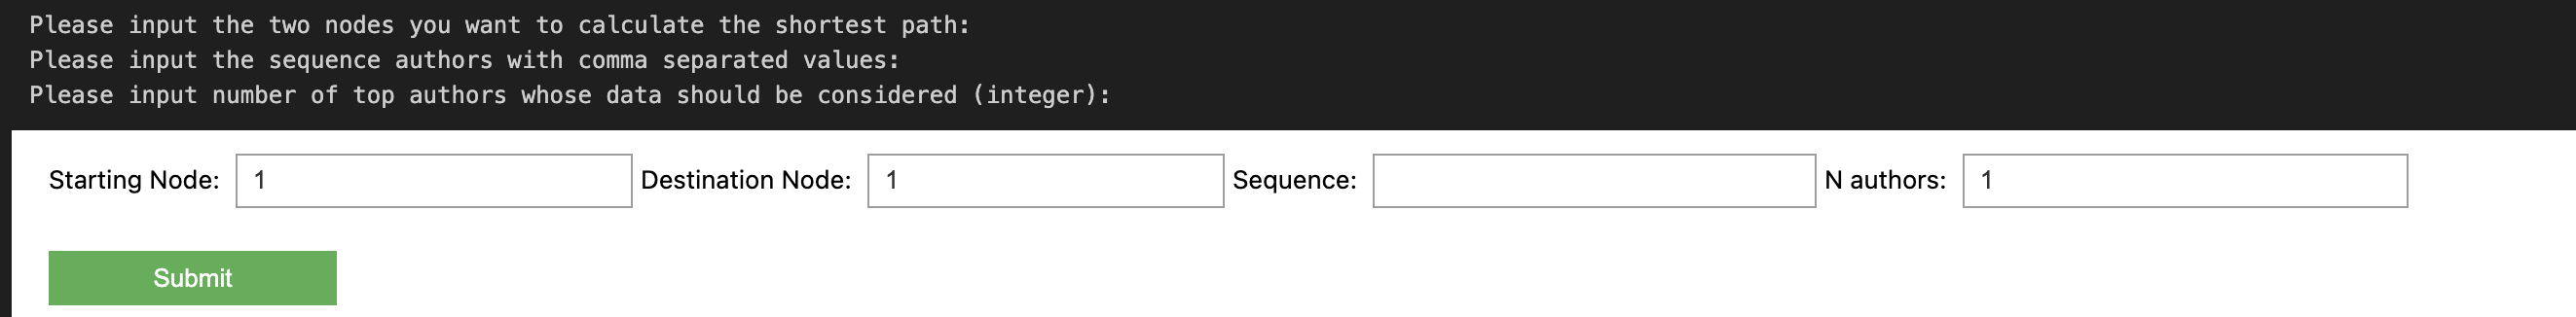

**Buttons sequence and inputs**    
Visualization System -> Collaboration Graph -> Shortest path -> 
Input: 
- N = 5
- First author: 2133227394
- Second author: 332422508
- Sequence: 173839695, 2111642879

Retrieving results; this could take some minutes, please wait...
Shortest path for 2133227394 and 332422508:
Cost Table:
+------+
| Cost |
+------+
|  22  |
+------+

Path Table:
+-------------------------+------------+------------+
|           Edge          | From Node  |  To Node   |
+-------------------------+------------+------------+
| (2133227394, 173839695) | 2133227394 | 173839695  |
| (173839695, 2111642879) | 173839695  | 2111642879 |
| (2111642879, 332422508) | 2111642879 | 332422508  |
+-------------------------+------------+------------+


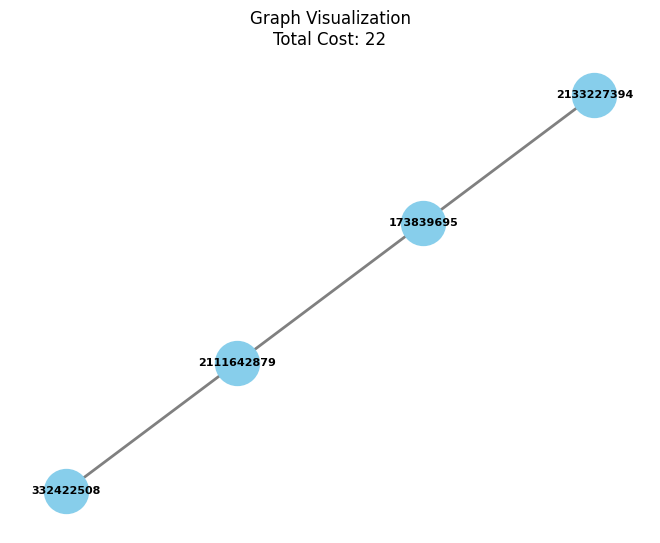

In [ ]:
%run ./frontend

---

<code style="background:red;color:black">**Little comment:**</code> <br>
The cost of this path (22) is crucial in understanding the most efficient route or connection between these two nodes in the context of the graph, where the edges may represent various relationships or distances. <br>
In the plot we can see how the nodes are connected, showing the path found.

---

### Visualization 4 - Visualize the disconnected graph

<code style="background:orange;color:black">**Introduction:**</code> <br>

A frontend function that constructs a networkx graph instance from the data and then plots the results, leveraging the backend function, has been implemented for this visualization request. Then, this function is used in the visualization system. We changed the graph labels from the authors' ids to their names for better visualization. 

This is how the menu for the inputs looks like for this functionality:

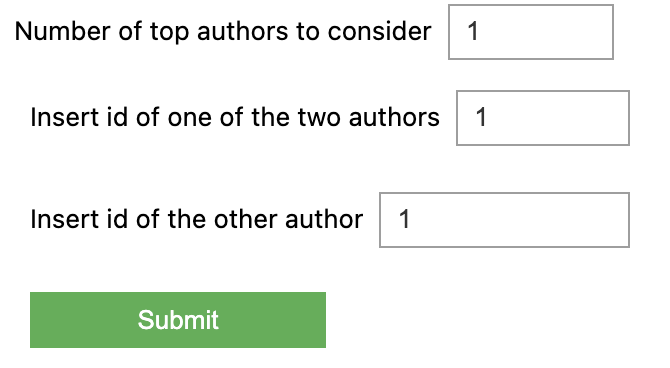

**Buttons sequence and inputs**   
Visualization System -> Collaboration Graph -> Disconnect two nodes -> 
Input: 
- N = 5
- First author: 332422508
- Second author: 173839695

Please wait: this functionality could take some minutes.
The number of the links that should be disconnected is 4 and the capacity of the cutset retrieved is 29


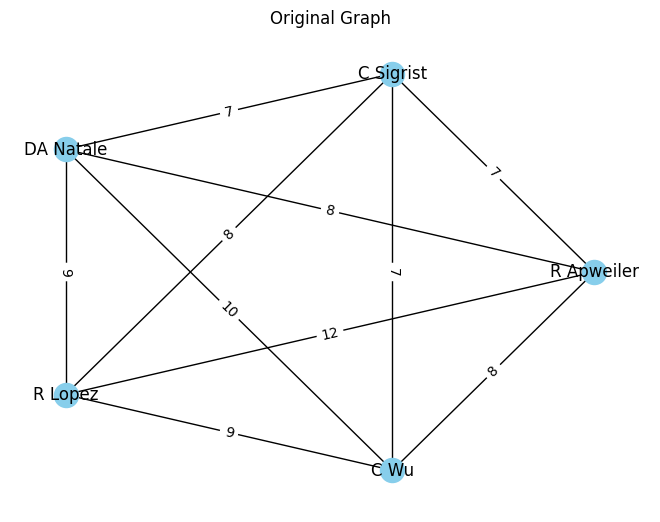

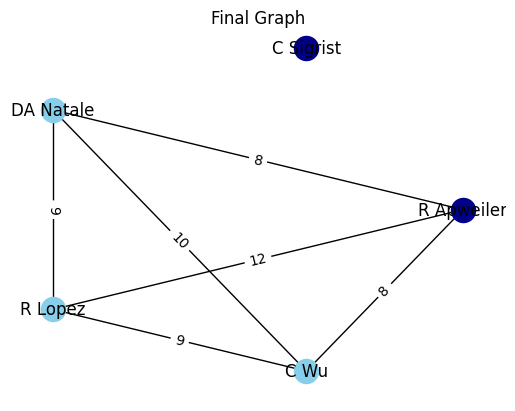

In [ ]:
%run ./frontend

---

<code style="background:red;color:black">**Little comment:**</code> <br>
In this case, the top 5 authors induce a clique, so in order to disconnect any two of the nodes of the graph, at least one of the two nodes has to be disconnected from all the othe nodes in the graph. Besides, to disconnect the nodes by removing the edges whose weights sum is minimal, we need to have *only one* of the two nodes disconnected from all the others, and in paritcoular, the one whose adjacent edges are "lighter".

---

### Visualization 5 - Visualize the communities

<code style="background:orange;color:black">**Introduction:**</code> <br>

As for the previous point, a frontend function that constructs a networkx graph instance from the data and then plots the results, leveraging the backend function, has been implemented for this visualization request. Then, this function is used in the visualization system after the buttons corrwsponding to this point have been selected.
In the visualization system we leverage the data we have to retrieve the papers' titles and show them in the table containing the communities instead of the paper ids; we decided not to change the graph's labels this time since the titles are long and they wouldn't have been readable in the plot.

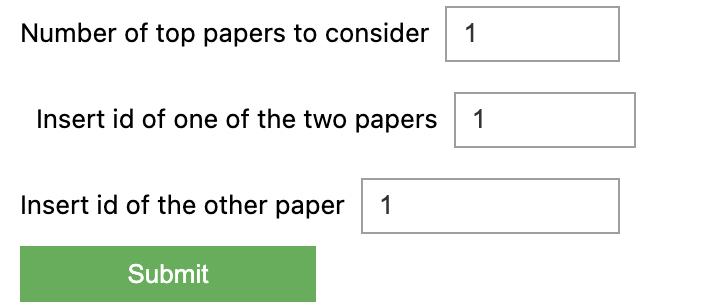

**Buttons sequence and inputs**   
Visualization System -> Citation Graph -> Detect Communities -> 
Input: 
- N = 20
- First paper: 2130509920
- Second paper: 2156909104

Please wait, this functionality could take a few seconds
The numbers of edges that has to be dropped to form communities is: 2
Communities Table: each row of the following table contains the papers in a "community" 
+------------------------------------------------------------------------------------------------+
|                                        Community nodes                                         |
+------------------------------------------------------------------------------------------------+
|                 ['Distinctive Image Features from Scale-Invariant Keypoints']                  |
|                         ['The Nature of Statistical Learning Theory']                          |
| ['Perceived usefulness, perceived ease of use, and user acceptance of information technology'] |
|              ['Genetic algorithms in search, optimization, and machine learning']              |
|                          ['The Mathematical Theory of Communication']                    

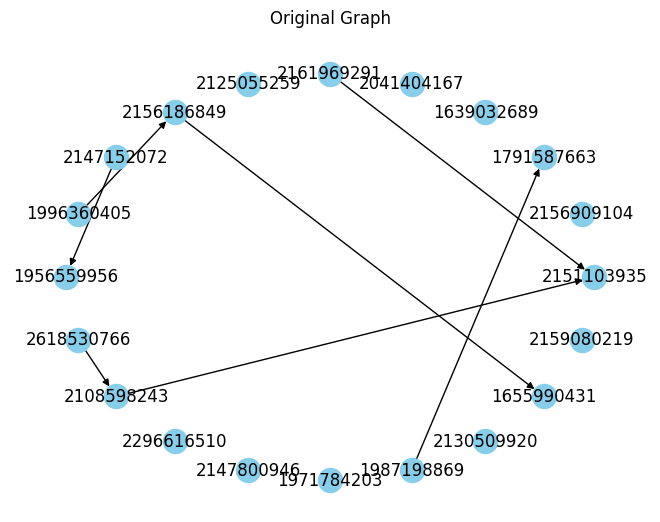

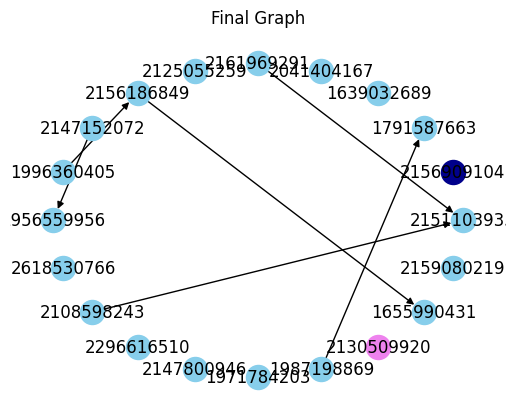

In [ ]:
%run ./frontend

---

<code style="background:red;color:black">**Little comment:**</code> <br>
The top 20 papers form a subgraph that is pretty sparse, and no relevant communities are detected. 

---

# 4. Command Line Question (CLQ)

**In this question, you should use any command line tools that you know to answer the following questions using the directed and unweighted graph that you have previously created: Citation graph:**

1. **Is there any node that acts as an important "connector" between the different parts of the graph?**
2. **How does the degree of citation vary among the graph nodes?**
3. **What is the average length of the shortest path among nodes?**

As it is really diccicult to answer the first and the third question using only shell scripts we decided to partly solve these questions using python (recommendend on slack: https://adm2023workspace.slack.com/archives/C05T7B2NK1S/p1704446515223949?thread_ts=1704220899.538789&cid=C05T7B2NK1S). We solved the second question only using command line tools. The  script can be found in our repository (name:CommandLine.sh) with further comments on the code. For all three questions we use our citation graph we created before and saved in a edgelist file. This file can also be found in our repository under the name grapho.txt. 

#### Question 1: 
To solve this question we decided to calculate the betweenness centrality of every node. It is basically normalized measure of how many of the shortest paths between nodes go through a node. Therefor we find it suitable to answer this question. As we know that our graph is diconnected we calculate the beetweenness similarity for every node on the largest connected subgraph. Then we extract the largest of these values and regard the corresponding node as the most important "connector". 

Here is the results: 
The node with the highest betweenness centrality score is: '99485931' 
It has a betweenness centrality score of: '9.513771610878111e-05'.
This score is very low,indicating there doesn't exist an important connector in our subgraph.

#### Question 2: 
We interprete the degree of citation as the number of times a paper gets cited. In other words: How many edges point to a node. To answer the question we use three measures: The difference between the node with the most incoming edges and the node with the least incoming edges, the average amount of incoming edges and the standard deviation of incoming edges over all nodes. 

Here are the results:
Difference of most and least cited paper is: '130'
The average of incoming nodes is: '6,47016'
The standard deviation is: '8,41722'. These results indicate that the degree of citations varies significanlty. Some get cited a lot, some hardly at all.

#### Question 3: 
To calculate the average shortest path among nodes, we again only work on the largest connected subgraph. 

Here are the results: 
The average shortest path length of the largest connected subgraph is: 5.204577993485163

For completeness, we show a screenshot of the results we get in our terminal.

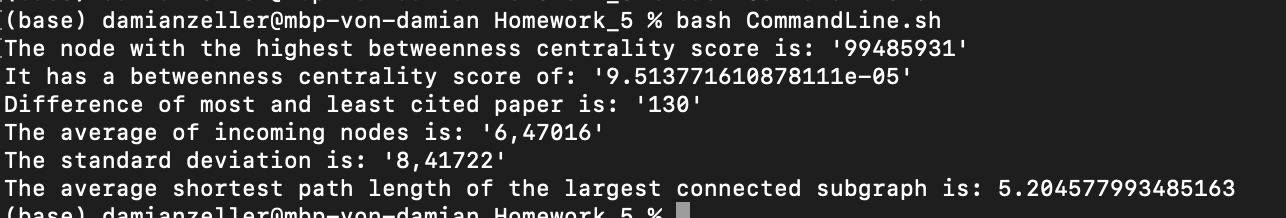

In [ ]:
from IPython.display import Image
display(Image(filename="/Users/damianzeller/Desktop/HS23/ADM/Homework_5/Results_CLQ.png",embed=True))